In [ ]:
# Install all modules
!pip install lxml requests bs4 pandas flair wordcloud

In [77]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
import pandas as pd
from datetime import datetime

# used to import model for sentiment analyze
from transformers import pipeline

# Flair is used for NER Organization names
from flair.data import Sentence
from flair.models import SequenceTagger
from concurrent.futures import ThreadPoolExecutor

# Connect with google sheets
from google.colab import auth
import gspread
from google.auth import default

# Use to draw graphs and wordcloud plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [ ]:
# Load all models
sentiment_pipeline = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")
tagger = SequenceTagger.load("flair/ner-english-large")

In [91]:
# organization name extraction function
def extract_organization_names(text):
  names = []
  sentence = Sentence(text)
  tagger.predict(sentence)
  for entity in sentence.get_spans('ner'):
      if entity.tag == "ORG":
        names.append(entity.text)
  return names

# Sentiment analyse function
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    sentiment_score = result['score']
    return sentiment_score

In [ ]:
# Make a requests Session
session = requests.Session()
session.headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'
}

# Term to fetch
term = "Green Hydrogen"

In [79]:
# Data taken from https://fm.cnbc.com/applications/cnbc.com/resources/search/cnbc-queryly-search-2022q2-results-page-prod.js

QUERYLY_DATA_URL = "https://fm.cnbc.com/applications/cnbc.com/resources/search/cnbc-queryly-search-2022q2-results-page-prod.js"

def get_querly_data():
  response = session.get(QUERYLY_DATA_URL)
  QUERYLY_KEY = response.text.split("QUERYLY_KEY")[1].split('"')[1].split('"')[0].strip()
  ADDITIONAL_INDEXES = response.text.split("ADDITIONAL_INDEXES")[1].split('"')[1].split('"')[0].strip()
  QUOTE_API_BASE = response.text.split("QUOTE_API_BASE")[1].split('"')[1].split('"')[0].strip()

  return QUERYLY_KEY, ADDITIONAL_INDEXES, QUOTE_API_BASE

# Get data by requesting everytime
QUERYLY_KEY, ADDITIONAL_INDEXES, QUOTE_API_BASE = get_querly_data()

# Write Hardcord values
#QUERYLY_KEY = "31a35d40a9a64ab3"
#ADDITIONAL_INDEXES = "4cd6f71fbf22424d,937d600b0d0d4e23,3bfbe40caee7443e,626fdfcd96444f28"
#QUOTE_API_BASE = "https://quote.cnbc.com/"

In [80]:
# Fetch headlines from CNBC function
def get_cnbc_news(num_of_pages=1,all_pages=False):
  data = []
  endindex = 0
  params = {
      "queryly_key":QUERYLY_KEY,
      "query":urllib.parse.quote(term.lower()),
      "endindex":str(endindex),
      "batchsize":"10",
      "callback":"",
      "showfaceted":"false",
      "timezoneoffset":"-330",
      "facetedfields":"formats",
      "facetedkey":urllib.parse.quote("formats|"),
      "facetedvalue":"!Press Release|",
      "needtoptickers":"1",
      "additionalindexes":ADDITIONAL_INDEXES
  }
  response = session.get(
      'https://api.queryly.com/cnbc/json.aspx',
      params=params
  )
  if response.status_code == 200:
    for i in response.json()["results"]:
      headline = i['cn:title']
      news_date = datetime.strptime(i['datePublished'], "%Y-%m-%dT%H:%M:%S%z").strftime("%Y-%m-%d %H:%M:%S")
      source_url = i['url']
      data.append({'Date': news_date, 'Headline': headline, 'Source': source_url})

  if all_pages:
    num_of_pages = response.json()['metadata']['totalpage']

  if num_of_pages > 1:
    for i in range(num_of_pages-1):
      endindex += 10
      params['endindex'] = str(endindex)
      response = session.get(
          'https://api.queryly.com/cnbc/json.aspx',
          params=params
      )
      if response.status_code == 200:
        for i in response.json()["results"]:
          headline = i['cn:title']
          news_date = datetime.strptime(i['datePublished'], "%Y-%m-%dT%H:%M:%S%z").strftime("%Y-%m-%d %H:%M:%S")
          source_url = i['url']
          data.append({'Date': news_date, 'Headline': headline, 'Source': source_url})

  return data

In [81]:
# Fetch headlines from GOOGLE News rss feed function
def get_rssfeed_news():
  data = []
  params = {
      "q":urllib.parse.quote(term.lower()),
      "hl":"en-IN",
      "gl":"IN",
      "ceid":"IN:en"
  }
  response = session.get(
      'https://news.google.com/rss/search',
      params=params
  )
  if response.status_code == 200:
    soup = BeautifulSoup(response.text,features="xml")
    for i in soup.findAll("item"):
      headline = i.find('title').text
      news_date = datetime.strptime(i.find('pubDate').text, "%a, %d %b %Y %H:%M:%S %Z").strftime("%Y-%m-%d %H:%M:%S")
      source_url = i.find('link').text
      data.append({'Date': news_date, 'Headline': headline, 'Source': source_url})
  return data


In [82]:
## Fetch all news

cnbc_data = get_cnbc_news() #Fetch the first 10 results
#cnbc_data = get_cnbc_news(num_of_pages=10) # Fetch by number of pages
#cnbc_data = get_cnbc_news(all_pages=True) # Fetch all pages for the term

rssfeed_data = get_rssfeed_news()

all_news = cnbc_data + rssfeed_data

# Make the dataframe
df = pd.DataFrame(all_news)

In [83]:
# add an extra column in this df called sentiment score
df['sentiment_score'] = df['Headline'].apply(analyze_sentiment)

# Sort the df by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date',ascending=False)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.reset_index(drop=True)

In [85]:
# Make your auth with google to update in sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
def write_google_sheet(sheet_name,data):
  sh = gc.create(sheet_name)
  spreadsheet_key = sh.url.split('/')[-1]
  worksheet = gc.open_by_key(spreadsheet_key).sheet1
  worksheet.append_rows([data.columns.values.tolist()] + data.values.tolist())
  gc.insert_permission(spreadsheet_key, None, 'anyone', 'reader')
  print(f"Google Sheet created and data added. Access link: {sh.url}")

# Write in sheet and update permission to anyone
write_google_sheet('GreenHydrogenNews',df)

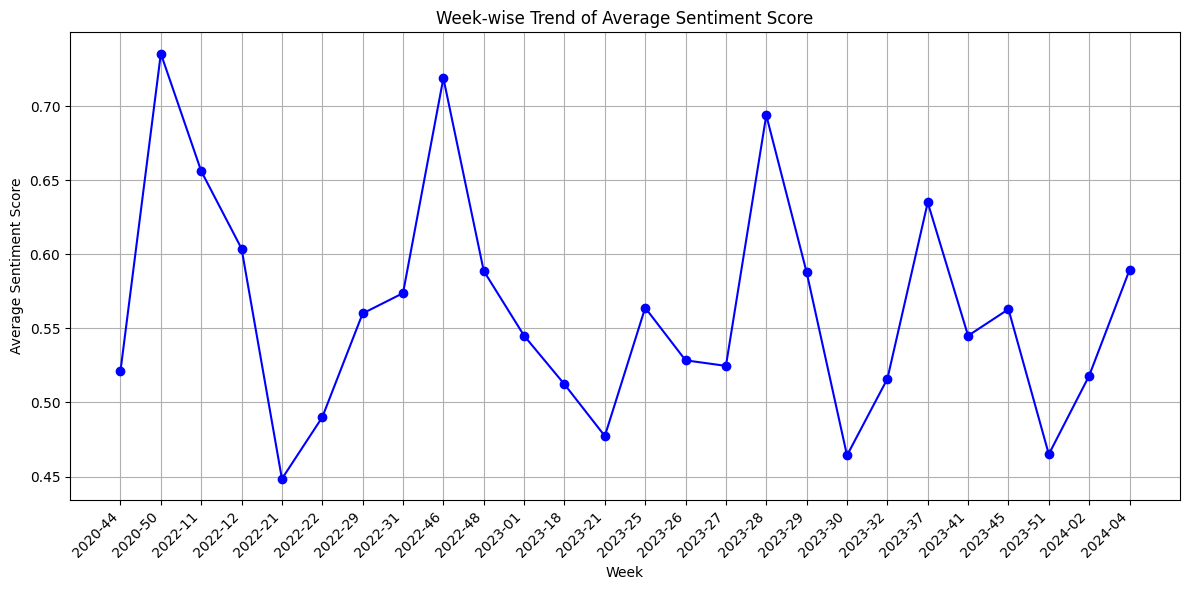

In [87]:
# Plot Week-wise Trend of Average Sentiment Score
# Plot X-Axis as Year-Week_number
# 2024-12 for 12th week of 2024

# Extract the week from the 'Date' column
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.strftime('%Y-%U')

# Group by week and calculate the average sentiment score
weekly_sentiment = df.groupby('Week')['sentiment_score'].mean()

# Plot the week-wise trend
plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment, marker='o', color='blue')
plt.title('Week-wise Trend of Average Sentiment Score')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
if len(weekly_sentiment) > 100:
  plt.xticks(range(0, len(weekly_sentiment), 5), weekly_sentiment.index[::5], rotation=45, ha='right')
else:
  plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
# Grab organization names
organization_names = []
for headline in df['Headline']:
    org_names = extract_organization_names(headline)
    organization_names.extend(org_names)

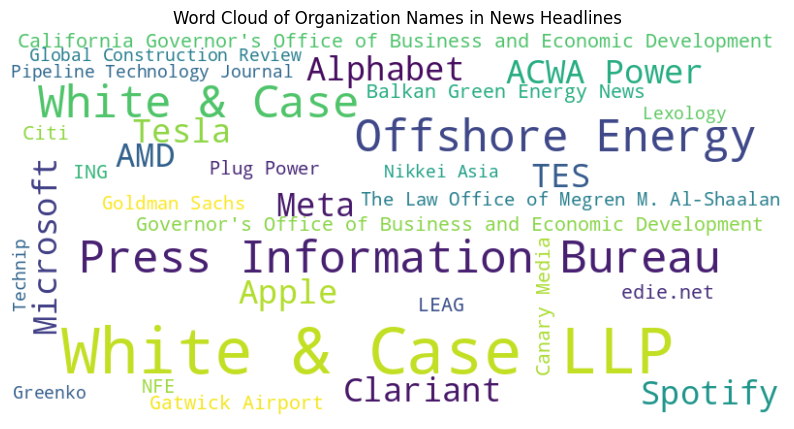

In [97]:
# Plot wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(Counter(organization_names))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Organization Names in News Headlines')
plt.show()